In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def gradient_penalty(D, x_true, x_fake, derivative):
    if len(x_true.shape) == 2:
        alpha = torch.rand(x_true.size()[0],1, device=x_true.device)
    else:
        alpha = torch.rand(x_true.size()[0],1,1,1, device=x_true.device)

    alpha = alpha.expand(x_true.size())
    interpolates = alpha * x_true + (1-alpha) * x_fake
    interpolates = torch.autograd.Variable(interpolates,requires_grad=True)
    disc_interpolates = D(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates,
                                    inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size(), device=x_true.device),
                                    create_graph=True,
                                    retain_graph=True,
                                    only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2,dim=1)-derivative) ** 2).mean() * 10
    return gradient_penalty

In [ ]:
def sample_swissroll(N):
    r = torch.sqrt(torch.linspace(0, 1, N)) * 780 * (2*np.pi)/360
    dx = -torch.cos(r)*r*0.05 + torch.rand(N) * (0.05)
    dy = torch.sin(r)*r*0.05 + torch.rand(N) * (0.05)
    x = torch.stack([dx, dy]).t()
    return x

def sample_gmm(N, k):
    x = torch.randn(N, 2)
    cluster_size = N // k
    for i in range(k):
        rand_std = torch.rand(1,2)*2 + 0.5
        rand_mu = torch.rand(1,2)*24 - 12
        x[i*cluster_size:(i+1)*cluster_size] = x[i*cluster_size:(i+1)*cluster_size] * rand_std + rand_mu
    return x

# 1. Training GAN

Original GAN objective for $G$ and $D$:

\begin{equation}
\min_G \max_D \quad \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)]+\mathbb{E}_{z \sim p_z{z}}[\log(1-D(G(z)))]
\end{equation}

Wassersten GAN objective for $D$:

\begin{equation}
\max_D \quad \mathbb{E}_{x \sim p_{data}(x)}[D(x)] - \mathbb{E}_{x \sim p_{fake}} [D(x)]
\end{equation}
subject to D is 1-Lipschitz.

In [ ]:
NUM_OF_POINTS = 2500
Z_DIM = 1

In [ ]:
x = sample_swissroll(NUM_OF_POINTS)

(-0.6869563579559326,
 0.5808869123458862,
 -0.6100384533405304,
 0.6839163839817047)

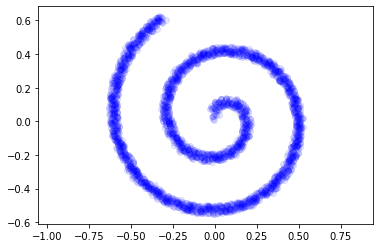

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c="b", alpha=0.1)
plt.axis("equal")

In [ ]:
G = torch.nn.Sequential(
    torch.nn.Linear(Z_DIM, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2)
)

D = torch.nn.Sequential(
    torch.nn.Linear(2, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)

In [ ]:
G

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
D

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
optim_g = torch.optim.Adam(lr=0.001, params=G.parameters())
optim_d = torch.optim.Adam(lr=0.001, params=D.parameters())
# most of the time you should set this to Adam optimizer.
# see: https://github.com/soumith/ganhacks by Soumith Chintala et al.

In [ ]:
EPOCH = 30
BATCH_SIZE = 50
LOOP_PER_EPOCH = NUM_OF_POINTS // BATCH_SIZE
WASSERSTEIN = False

### Initial state

(-0.7316798329353332,
 0.582721745967865,
 -1.0993127673864365,
 0.7116398066282272)

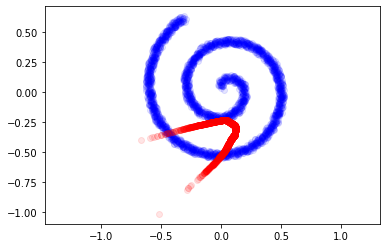

In [ ]:
with torch.no_grad():
    z = torch.randn(NUM_OF_POINTS, Z_DIM)
    x_fake = G(z)
plt.scatter(x[:, 0], x[:, 1], c="b", alpha=0.1)
plt.scatter(x_fake[:, 0], x_fake[:, 1], c="r", alpha=0.1)
plt.axis("equal")

### Epoch loop

In [ ]:
D_loss_hist = []
G_loss_hist = []

In [ ]:
for e in range(EPOCH):
    D_running_loss = 0.0
    G_running_loss = 0.0
    # for shuffling data
    # e.g. [1, 2, 3, 4, 5] -> [3, 5, 1, 4, 2]
    R = torch.randperm(NUM_OF_POINTS)
    for i in range(LOOP_PER_EPOCH):
        #######################
        # TRAIN DISCRIMINATOR #
        #######################


        # first, generate some fake data.
        # we should not train G in the discriminator
        # training loop.
        with torch.no_grad():
            z = torch.randn(BATCH_SIZE, Z_DIM)
            x_fake = G(z)

        # draw some real data.
        x_real = x[R[i*BATCH_SIZE:(i+1)*BATCH_SIZE]]
        # estimate logits
        logit_real = D(x_real)
        logit_fake = D(x_fake)

        if WASSERSTEIN:
            # try to increase discrepancy by
            # decreasing logit_fake
            # increasing logit_real
            D_loss = (logit_fake-logit_real).mean()
            # with respect to: 
            # D is 1-Lipschitz (i.e. grad(D, x) <= 1)
            D_loss += gradient_penalty(D, x_real, x_fake, derivative=1)
            # (though they actually use grad(D, x) == 1)
            # D approximates Wasserstein-1 distance.

        else:
            # estimate probabilities
            p_real = torch.sigmoid(logit_real)
            p_fake = torch.sigmoid(logit_fake)
            # compute loss
            D_loss = -(torch.log(p_real) + torch.log(1-p_fake)).mean()

        # compute gradients
        optim_d.zero_grad()
        D_loss.backward()
        # gradient descent step
        optim_d.step()
        # log
        D_running_loss += D_loss.item() / 1

        #######################
        #   TRAIN GENERATOR   #
        #######################

        # first, stop the unnecessary gradient computation
        # for the discriminator, as we are optimizing for G.
        for p in D.parameters():
            p.requires_grad = False

        z = torch.randn(BATCH_SIZE, Z_DIM)
        x_fake = G(z)
        logit_fake = D(x_fake)
        if WASSERSTEIN:
            # try to decrease the discrepancy by taking a step
            # in the opposite direction of the objective of D.
            # increase logit_fake
            G_loss = -(logit_fake).mean()
        else:
            p_fake = torch.sigmoid(logit_fake)
            # compute loss
            # G_loss = -(-torch.log(1-p_fake)).mean()

            # an alternative better behaved loss
            # treat generated samples as real, and try to
            # increase the realness probability of fake samples
            G_loss = -(torch.log(p_fake)).mean()

        # compute gradients
        optim_g.zero_grad()
        G_loss.backward()
        # gradient descent step
        optim_g.step()
        # log
        G_running_loss += G_loss.item()

        # now we can open the gradient valves for D.
        for p in D.parameters():
            p.requires_grad = True

    D_running_loss /= LOOP_PER_EPOCH
    D_loss_hist.append(D_running_loss)
    G_running_loss /= LOOP_PER_EPOCH
    G_loss_hist.append(G_running_loss)

    print("Epoch: %d - D loss: %.5f, G loss: %.5f" % (e+1, D_running_loss, G_running_loss))

Epoch: 1 - D loss: 1.38930, G loss: 0.68919
Epoch: 2 - D loss: 1.38442, G loss: 0.68205
Epoch: 3 - D loss: 1.35015, G loss: 0.69693
Epoch: 4 - D loss: 1.32094, G loss: 0.73094
Epoch: 5 - D loss: 1.46332, G loss: 0.64218
Epoch: 6 - D loss: 1.30806, G loss: 0.84517
Epoch: 7 - D loss: 1.40926, G loss: 0.77699
Epoch: 8 - D loss: 1.46597, G loss: 0.60766
Epoch: 9 - D loss: 1.41963, G loss: 0.62354
Epoch: 10 - D loss: 1.40186, G loss: 0.63901
Epoch: 11 - D loss: 1.38199, G loss: 0.65958
Epoch: 12 - D loss: 1.36882, G loss: 0.68004
Epoch: 13 - D loss: 1.38330, G loss: 0.67819
Epoch: 14 - D loss: 1.42056, G loss: 0.66917
Epoch: 15 - D loss: 1.36481, G loss: 0.74993
Epoch: 16 - D loss: 1.39842, G loss: 0.71262
Epoch: 17 - D loss: 1.40873, G loss: 0.69368
Epoch: 18 - D loss: 1.38818, G loss: 0.72105
Epoch: 19 - D loss: 1.38459, G loss: 0.70675
Epoch: 20 - D loss: 1.40012, G loss: 0.68353
Epoch: 21 - D loss: 1.38568, G loss: 0.68601
Epoch: 22 - D loss: 1.36583, G loss: 0.72039
Epoch: 23 - D loss:

(-0.6878729850053787,
 0.5806357055902481,
 -0.6099012196063995,
 0.6883344948291779)

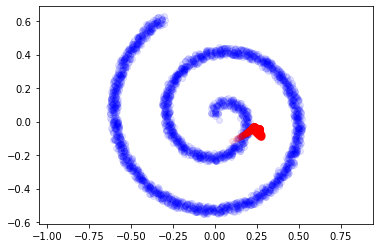

In [ ]:
with torch.no_grad():
    z = torch.randn(NUM_OF_POINTS, Z_DIM)
    x_fake = G(z)
plt.scatter(x[:, 0], x[:, 1], c="b", alpha=0.1)
plt.scatter(x_fake[:, 0], x_fake[:, 1], c="r", alpha=0.1)
plt.axis("equal")

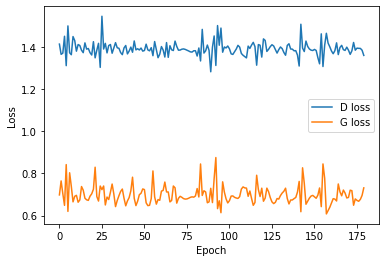

In [ ]:
plt.plot(D_loss_hist, label="D loss")
plt.plot(G_loss_hist, label="G loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

# 2. Using GANs to enforce a specific distribution

This application is first proposed in Adversarial Autoencoders, but it is a general procedure and can be applied to many problems.

In [ ]:
EPOCH = 30
BATCH_SIZE = 128
WASSERSTEIN = False

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
x, y = iter(loader).next()

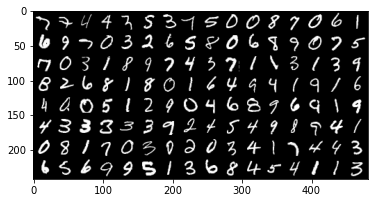

In [ ]:
canvas = torchvision.utils.make_grid(x, nrow=16)
plt.imshow(canvas.permute(1,2,0))

In [ ]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(784, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Tanh()
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 784)
)
discriminator = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
)

In [ ]:
encoder.to("cuda")
decoder.to("cuda")
discriminator.to("cuda")

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
optim_g = torch.optim.Adam(lr=0.0001, params=[{"params": encoder.parameters()},
                                             {"params": decoder.parameters()}])
optim_d = torch.optim.Adam(lr=0.0001, params=discriminator.parameters())

### Initial state 

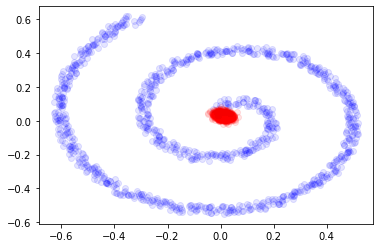

In [ ]:
loader2 = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)
x, y = iter(loader2).next()
with torch.no_grad():
    h = encoder(x.reshape(x.shape[0], -1).to("cuda")).cpu()
h_real = sample_swissroll(1000)
plt.scatter(h_real[:, 0], h_real[:, 1], c="b", alpha=0.1)
plt.scatter(h[:, 0], h[:, 1], c="r", alpha=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


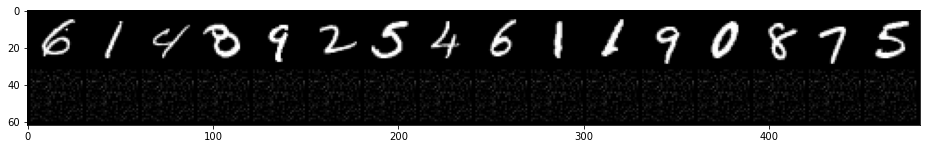

In [ ]:
loader3 = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)
x, y = iter(loader3).next()
with torch.no_grad():
    h = encoder(x.reshape(16, -1).to("cuda"))
    x_bar = decoder(h)
    x_bar = x_bar.reshape(16, 1, 28, 28).cpu()
x_all = torch.cat([x, x_bar])
canvas = torchvision.utils.make_grid(x_all, nrow=16)
plt.figure(figsize=(16, 4))
plt.imshow(canvas.permute(1, 2, 0))

In [ ]:
D_loss_hist = []
G_loss_hist = []
MSE_loss_hist = []

In [ ]:
for e in range(EPOCH):
    MSE_running_loss = 0.0
    D_running_loss = 0.0
    G_running_loss = 0.0
    for i, (x, y) in enumerate(loader):
        #######################
        #  TRAIN AUTOENCODER  #
        #######################
        x = x.reshape(x.shape[0], -1).to("cuda")
        h = encoder(x)
        x_bar = decoder(h)
        mse_loss = ((x-x_bar)**2).mean()

        optim_g.zero_grad()
        mse_loss.backward()
        optim_g.step()
        
        MSE_running_loss += mse_loss.item()

        #######################
        # TRAIN DISCRIMINATOR #
        #######################
        with torch.no_grad():
            h_fake = encoder(x)
        h_real = sample_swissroll(x.shape[0]).to("cuda")
        
        logit_real = discriminator(h_real)
        logit_fake = discriminator(h_fake)

        if WASSERSTEIN:
            D_loss = (logit_fake-logit_real).mean()
            D_loss += gradient_penalty(discriminator, h_real, h_fake, derivative=1)
        else:
            p_real = torch.sigmoid(logit_real)
            p_fake = torch.sigmoid(logit_fake)
            D_loss = -(torch.log(p_real) + torch.log(1-p_fake)).mean()

        D_loss *= 0.1
        optim_d.zero_grad()
        D_loss.backward()
        optim_d.step()
        D_running_loss += D_loss.item()

        #######################
        #   TRAIN GENERATOR   #
        #######################
        for p in discriminator.parameters():
            p.requires_grad = False

        h_fake = encoder(x)
        logit_fake = discriminator(h_fake)
        if WASSERSTEIN:
            G_loss = -(logit_fake).mean()
        else:
            p_fake = torch.sigmoid(logit_fake)
            G_loss = -(torch.log(p_fake)).mean()

        G_loss *= 0.1
        optim_g.zero_grad()
        G_loss.backward()
        optim_g.step()
        G_running_loss += G_loss.item()

        for p in discriminator.parameters():
            p.requires_grad = True

    D_running_loss /= (i+1)
    D_loss_hist.append(D_running_loss)
    G_running_loss /= (i+1)
    G_loss_hist.append(G_running_loss)
    MSE_running_loss /= (i+1)
    MSE_loss_hist.append(MSE_running_loss)

    print("Epoch: %d- MSE loss: %.5f, D loss: %.5f, G loss: %.5f" % (e+1, MSE_running_loss, D_running_loss, G_running_loss))

Epoch: 1- MSE loss: 0.04349, D loss: 0.13772, G loss: 0.07001
Epoch: 2- MSE loss: 0.04346, D loss: 0.13776, G loss: 0.07000
Epoch: 3- MSE loss: 0.04340, D loss: 0.13778, G loss: 0.06999
Epoch: 4- MSE loss: 0.04333, D loss: 0.13782, G loss: 0.06998
Epoch: 5- MSE loss: 0.04326, D loss: 0.13784, G loss: 0.06997
Epoch: 6- MSE loss: 0.04320, D loss: 0.13785, G loss: 0.06995
Epoch: 7- MSE loss: 0.04314, D loss: 0.13787, G loss: 0.06994
Epoch: 8- MSE loss: 0.04308, D loss: 0.13787, G loss: 0.06994
Epoch: 9- MSE loss: 0.04303, D loss: 0.13790, G loss: 0.06992
Epoch: 10- MSE loss: 0.04298, D loss: 0.13791, G loss: 0.06991
Epoch: 11- MSE loss: 0.04292, D loss: 0.13795, G loss: 0.06991
Epoch: 12- MSE loss: 0.04287, D loss: 0.13795, G loss: 0.06989
Epoch: 13- MSE loss: 0.04282, D loss: 0.13796, G loss: 0.06988
Epoch: 14- MSE loss: 0.04279, D loss: 0.13800, G loss: 0.06988
Epoch: 15- MSE loss: 0.04272, D loss: 0.13800, G loss: 0.06986
Epoch: 16- MSE loss: 0.04269, D loss: 0.13803, G loss: 0.06987
E

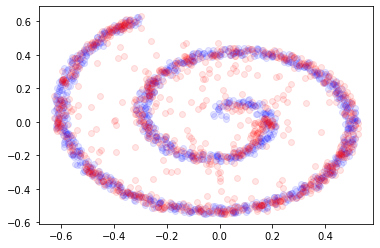

In [ ]:
loader2 = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)
x, y = iter(loader2).next()
with torch.no_grad():
    h = encoder(x.reshape(x.shape[0], -1).to("cuda")).cpu()
h_real = sample_swissroll(1000)
plt.scatter(h_real[:, 0], h_real[:, 1], c="b", alpha=0.1)
plt.scatter(h[:, 0], h[:, 1], c="r", alpha=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


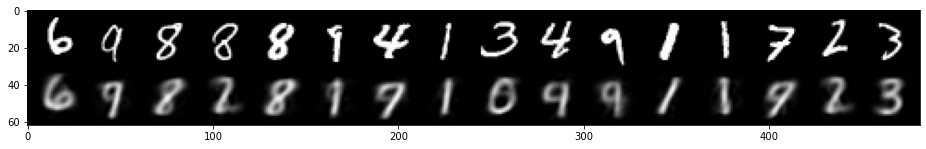

In [ ]:
loader3 = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)
x, y = iter(loader3).next()
with torch.no_grad():
    h = encoder(x.reshape(16, -1).to("cuda"))
    x_bar = decoder(h)
    x_bar = x_bar.reshape(16, 1, 28, 28).cpu()
x_all = torch.cat([x, x_bar])
canvas = torchvision.utils.make_grid(x_all, nrow=16)
plt.figure(figsize=(16, 4))
plt.imshow(canvas.permute(1, 2, 0))

In [ ]:
plt.plot(D_loss_hist, label="D loss")
plt.plot(G_loss_hist, label="G loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()